# Iowa Liquor Project

We want to predict 2016 liquor sales in the state of Iowa using state provided liquor store sales data from 2015. Using this data, we want to identify trends in sales volume and profits by store to accurately predict these trends in 2016.

### Libraries

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import and clean data

In [116]:
# Import, convert 'Date' col to datetime
liquor=pd.read_csv('../Assets/Iowa_Liquor_sample.csv',parse_dates=['Date'],infer_datetime_format=True)
liquor.columns

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')

In [117]:
# format column names
import re

liquor.columns = [re.sub("[^a-zA-Z]+", "", x) for x in liquor.columns]

In [118]:
# remove '$' in values and convert to numeric
adjust_cols = ['StateBottleCost','StateBottleRetail','SaleDollars']

for col in adjust_cols:
    liquor[col] = pd.to_numeric(liquor[col].str.replace('$',''),errors='coerce')

In [119]:
# drop null values
liquor = liquor.dropna()

### Split Data to Create a features and targets

To make predictions, we need two sets of data:
* Total full-year  sales for each store in 2015 (our target / y)
* Data from Q1 2015 (will become our features / X)


In [120]:
# Filter to only 2015
liquor2015 = liquor[liquor.Date.dt.year==2015]

# Calculate the sum of sales for each store in 2015 by grouping the full year data
liquor2015_fy = liquor2015[["StoreNumber", "SaleDollars"]]
liquor2015_fy = liquor2015_fy.groupby("StoreNumber", as_index=False).sum()

# Filter to just Q1 data: 
liquor2015_q1 = liquor2015[liquor2015.Date.dt.quarter==1]

### Feature Engineering and Selection



In [121]:
#Create profit variable
liquor2015_q1["profit"] = liquor2015_q1.StateBottleRetail - liquor2015_q1.StateBottleCost

#Group by StoreNumber
group = liquor2015_q1.groupby(["StoreNumber"], as_index=False)["SaleDollars", "VolumeSoldLiters", "profit"].agg(["sum", "mean"])

#Collapse and rename variables
group.columns = ['_'.join(var).strip() for var in group.columns.values]
group.columns = [var + "_q1" for var in group.columns.values]
group.reset_index(inplace=True)

# Dataframe of Q1 features
liquor2015_q1_features = group[["StoreNumber", "SaleDollars_sum_q1", "VolumeSoldLiters_mean_q1", "profit_mean_q1"]]

# Combine Q1 Features with Full Year Target
liquor2015_combined = liquor2015_fy.merge(liquor2015_q1_features, on="StoreNumber")

/Users/samuelasilber/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Cross Validation


In [122]:
# Step 1: Hold Out / Testing Data
from sklearn.model_selection import train_test_split
training_data,holdout = train_test_split(liquor2015_combined,shuffle=True,test_size=0.10,random_state=123)

In [123]:
# Step 2: Kfolds
from sklearn.cross_validation import KFold

# Number of folds
folds = 10

# Number of rows in dataframe
n = training_data.shape[0]

kf = KFold(n, n_folds=folds, random_state=123)

### Model Building - Linear Regression

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np

#select feature column names
feature_cols = ["SaleDollars_sum_q1", "VolumeSoldLiters_mean_q1", "profit_mean_q1"]

# define X (features) and y (target)
X = training_data[feature_cols]
y = training_data["SaleDollars"]

#Instantiate model
lr = LinearRegression()

In [125]:
# Use K-Folds cross validation to train model
# Create a blank list to store fold scores
MSE_scores = []
MAE_scores = []
RMSE_scores = []
R2_scores = []
n = 1

for train,test in kf:
    # Set up training and testing sets
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    # Fit model on training x and training y
    lr.fit(x_train,y_train)
    
    # Make Predictions
    y_preds = lr.predict(x_test)

    # Score predictions vs. true values using a variety of metrics
    MSE_score = mean_squared_error(y_true, y_preds)
    MAE_score = mean_absolute_error(y_true, y_preds)
    RMSE_score = np.sqrt(mean_squared_error(y_true, y_preds))
    R2_score = r2_score(y_true, y_preds)
    
    # Append scores 
    MSE_scores.append(MSE_score)
    MAE_scores.append(MAE_score)
    RMSE_scores.append(RMSE_score)
    R2_scores.append(R2_score)
    
    print "Fold", n 
    print "MSE:", MSE_score    
    print "MAE:", MAE_score
    print "RMSE:", RMSE_score
    print "R2:", R2_score
    n +=1

Fold 1
MSE: 48445987.1413
MAE: 3847.70747734
RMSE: 6960.31516106
R2: 0.95302609913
Fold 2
MSE: 96599875.9206
MAE: 4123.10196907
RMSE: 9828.52358803
R2: 0.948387610421
Fold 3
MSE: 71712122.5311
MAE: 4363.87089146
RMSE: 8468.30104159
R2: 0.860289204396
Fold 4
MSE: 69785579.4325
MAE: 4234.28833635
RMSE: 8353.77635758
R2: 0.969394544878
Fold 5
MSE: 53993998.1235
MAE: 3706.09616271
RMSE: 7348.06084103
R2: 0.933555915278
Fold 6
MSE: 211994982.106
MAE: 6761.29974709
RMSE: 14560.0474623
R2: 0.977240604611
Fold 7
MSE: 222607077.95
MAE: 5311.10930855
RMSE: 14920.0227195
R2: 0.976538172207
Fold 8
MSE: 55211711.2276
MAE: 4602.22039444
RMSE: 7430.45834573
R2: 0.906605374091
Fold 9
MSE: 169000882.658
MAE: 5069.33464169
RMSE: 13000.0339483
R2: 0.838532137585
Fold 10
MSE: 108472719.121
MAE: 5533.03319175
RMSE: 10415.0237216
R2: 0.924853674532


In [126]:
print "MSE:", np.mean(MSE_scores)
print "MAE:", np.mean(MAE_scores)
print "RMSE:", np.mean(RMSE_scores)
print "R2:", np.mean(R2_scores)

MSE: 110782493.621
MAE: 4755.20621205
RMSE: 10128.4563187
R2: 0.928842333713


In [127]:
#Coefficients
list(zip(feature_cols,lr.coef_))

[('SaleDollars_sum_q1', 4.5357313894021383),
 ('VolumeSoldLiters_mean_q1', -174.99289907997718),
 ('profit_mean_q1', 473.31706031277599)]

In [128]:
#Intercept
lr.intercept_

-449.57616263579621

### Test against hold-out set

In [129]:
features = ["SaleDollars_sum_q1", "VolumeSoldLiters_mean_q1", "profit_mean_q1"]

X_train = training_data[features]
y_train = training_data["SaleDollars"]

x_holdout = holdout[features]
y_holdout = holdout["SaleDollars"]


#Instantiate and train linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create predictions using holdout set (x_holdout)
holdout_preds = lr.predict(x_holdout)

#Scores
MAE_score = mean_absolute_error(y_holdout, holdout_preds)
MSE_score = mean_squared_error(y_holdout, holdout_preds)
RMSE_score = np.sqrt(mean_squared_error(y_holdout, holdout_preds))
R2_score = r2_score(y_holdout, holdout_preds)
                     
                     
#Print Scores
print "MSE:", np.mean(MSE_score)
print "MAE:", np.mean(MAE_score)
print "RMSE:", np.mean(RMSE_score)
print "R2:", np.mean(R2_score)

MSE: 106218031.312
MAE: 5318.97769077
RMSE: 10306.2132383
R2: 0.945481457822


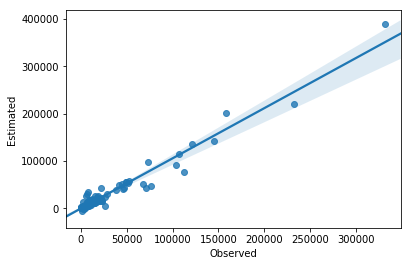

In [130]:
#Regplot predictions vs observed  
plot = sns.regplot(y_holdout, holdout_preds)
plot.set_xlabel("Observed")
plot.set_ylabel("Estimated")

The model looks like it's predicting fairly accurately for stores that made less than $50,000 in 2015. After $50,000 the residuals are much larger and the model becomes slightly less accurate. It is obviously these larger observations that are driving up metrics like MSE/MAE/RMSE, but the overall fit looks pretty good!

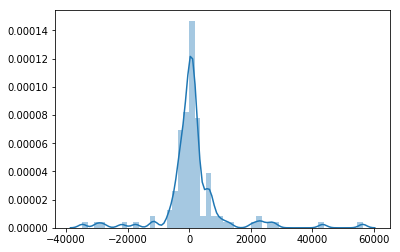

In [131]:
#Residuals
residuals = [est - obs for est, obs in zip(holdout_preds, y_holdout)]
sns.distplot(residuals)


Looks like the variance (i.e., random error) of the residuals is normally distributed. This means that our assumption of normality is correct.

### 2016 Prediction

In [132]:
# Filter to 2016
liquor2016_fy = liquor[liquor.Date.dt.year==2016]
liquor2016_q1 = liquor2016[liquor.Date.dt.quarter==1]

#Create profit variable
liquor2016_q1["profit"] = liquor2016_q1.StateBottleRetail - liquor2016_q1.StateBottleCost

#Group by StoreNumber
group = liquor2016_q1.groupby(["StoreNumber"], as_index=False)["SaleDollars", "VolumeSoldLiters", "profit"].agg(["sum", "mean"])

#Collapse and rename variables
group.columns = ['_'.join(var).strip() for var in group.columns.values]
group.columns = [var + "_q1" for var in group.columns.values]
group.reset_index(inplace=True)

# Dataframe of Q1 features
liquor2016_q1_features = group[["StoreNumber", "SaleDollars_sum_q1", "VolumeSoldLiters_mean_q1", "profit_mean_q1"]]

# Combine Q1 Features with Full Year Target
liquor2016_combined = liquor2016_fy.merge(liquor2015_q1_features, on="StoreNumber")


/Users/samuelasilber/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
# Filter to only 2016
liquor2016 = liquor[liquor.Date.dt.year==2016]

# Filter to just Q1 data: 
liquor2016_q1 = liquor2016[liquor2016.Date.dt.quarter==1]

#Create profit variable
liquor2016_q1["profit"] = liquor2016_q1.StateBottleRetail - liquor2016_q1.StateBottleCost

#Group by StoreNumber
group = liquor2016_q1.groupby(["StoreNumber"])["SaleDollars", "VolumeSoldLiters", "profit"].agg(["sum", "mean"])

#Collapse and rename variables
group.columns = ['_'.join(var).strip() for var in group.columns.values]
group.columns = [var + "_q1" for var in group.columns.values]
#group.reset_index(inplace=True)


# #Dataframe of Q1 features
liquor2016_q1_features = group[["SaleDollars_sum_q1", "VolumeSoldLiters_mean_q1", "profit_mean_q1"]]

#predict
pred_2016 = lr.predict(liquor2016_q1_features)
sum_2016 = pred_2016.sum()

print "Sales in 2016:", sum_2016

Sales in 2016: 28316215.3004


# Evaluation:

The best set of features I found were Q1 sales, Q1 average profit, and Q1 average volume of liquor sold in liters. These features had some of the highest correlations with total Sales in dollars, and cross-validation confirmed their predictive value. I was happy with the results of the testing set, producing an average RMSE of 10128.46 and an average R-squared of 0.93.

For the holdout set, the model had a higher R-squared (.95) than the average testing R-squared, though the error metrics were slightly higher across the board (RMSE of 10306.21). In this sense I'd say it performed slightly worse, only because the error metrics are those most tangible to the Iowa state tax board when projecting actual numbers for future sales.

